In [34]:
from multiprocessing import Pool

import pandas as pd
import numpy as np
# RLE 디코딩 함수
def rle_decode(mask_rle, shape=(224,224)):

    if mask_rle == -1 or mask_rle == '-1':
        return np.zeros(shape)
     
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
# ... (여기에 rle_encode와 rle_decode 함수를 넣으십시오)

def process_image(args):
    id_, submissions, weights, threshold, shape, no_building_threshold = args
    masks = [rle_decode(submit.loc[submit['img_id']==id_, 'mask_rle'].values[0], shape) for submit in submissions]
    weights_ = [weight if np.any(mask != 0) else 0 for mask, weight in zip(masks, weights)]
    no_building_count = weights_.count(0)
    if no_building_count >= 3:
        return '-1'
    else:
    # no_building_weight = sum([weight for mask, weight in zip(masks, weights) if np.all(mask == 0)])
    # if no_building_weight >= no_building_threshold:
    #     return '-1'
    # else:
        ensemble_mask = np.zeros(shape)
        for mask, weight in zip(masks, weights):
            ensemble_mask += weight * mask
        ensemble_mask = (ensemble_mask >= threshold).astype(np.uint8)
        if np.all(ensemble_mask == 0):
            return '-1'
        else:
            return rle_encode(ensemble_mask)
        # return rle_encode(ensemble_mask)

def ensemble_parallel(submissions, weights, threshold=50, shape=(224,224), no_building_threshold=50):
    # 각 제출물의 ID 열이 일치하도록 확인합니다
    for submit in submissions[1:]:
        assert np.all(submissions[0]['img_id'] == submit['img_id'])

    final_submit = pd.DataFrame()
    final_submit['img_id'] = submissions[0]['img_id']

    with Pool() as p:
        final_masks = p.map(process_image, [(id_, submissions, weights, threshold, shape, no_building_threshold) for id_ in final_submit['img_id']])

    final_submit['mask_rle'] = final_masks

    return final_submit

submit1 = pd.read_csv('/home/ubin108/0728_unet_convNext_xlarge_mask0.55.csv')
submit2 = pd.read_csv('/home/ubin108/0728_uper_convnext_xlarge_best_8178_95_mask_0.55.csv')
submit3 = pd.read_csv('/home/ubin108/0728_unet_convnext_large_in22ft1k_train95_mask0.6.csv')
submit4 = pd.read_csv('/home/ubin108/0727_upernet_convnext_large_0.80845_mask0.6.csv')
submit5 = pd.read_csv('/home/ubin108/0727_unet_efficientnetV2_l_80803_mask0.6.csv')
submit6 = pd.read_csv('/home/ubin108/0727_unet_convNext_base_8062_mask0.6.csv')

final_submit = ensemble_parallel([submit1, submit2, submit3, submit4, submit5, submit6], [30, 30, 20, 20, 20, 20])
# unet convxlarge, uper convxlarge, uper convlarge, unet efflarge, unet convlarge, unet convbase  
final_submit.to_csv('./0728_ensemble_6_building_3_threshold_0.55_[30, 30, 20, 20, 20, 20].csv', index=False)

In [5]:
import pandas as pd

# csv 파일을 읽어 DataFrame을 생성합니다.
df = pd.read_csv('./0724_ensemble_5_building_2_V2.csv')

# 'mask_rle' 컬럼이 빈 값을 가지는 행을 찾습니다.
empty_mask_rle = df[df['mask_rle'].isna() | (df['mask_rle'] == '')]

# 빈 'mask_rle'을 가진 행을 출력합니다.
print(empty_mask_rle)

Empty DataFrame
Columns: [img_id, mask_rle]
Index: []


In [ ]:
import cv2
import numpy as np

# 이미지를 로드합니다. 이 경우, 빌딩이 1로, 그 외 영역이 0으로 마스킹된 이미지입니다.
# 'image_path'를 해당 이미지 경로로 교체해야 합니다.
image = cv2.imread('image_path', cv2.IMREAD_GRAYSCALE)

# 이미지가 이진화되어 있다고 가정하고 빌딩 부분만 255로 만듭니다. 
# 이진 이미지가 아니라면, 이진화 과정이 필요할 수 있습니다.
image = image * 255

# 이미지에서 커널을 정의하고 딜레이션을 실행합니다.
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(image,kernel,iterations = 1)

# 딜레이션 이미지와 원본 이미지를 빼서 테두리를 얻습니다.
border = dilation - image

# 전체 빌딩 픽셀 수와 테두리 픽셀 수를 계산합니다.
total_building_pixels = np.sum(image > 0)
border_pixels = np.sum(border > 0)

# 테두리의 비율을 계산합니다.
border_ratio = border_pixels / total_building_pixels
print("The border ratio is: ", border_ratio)


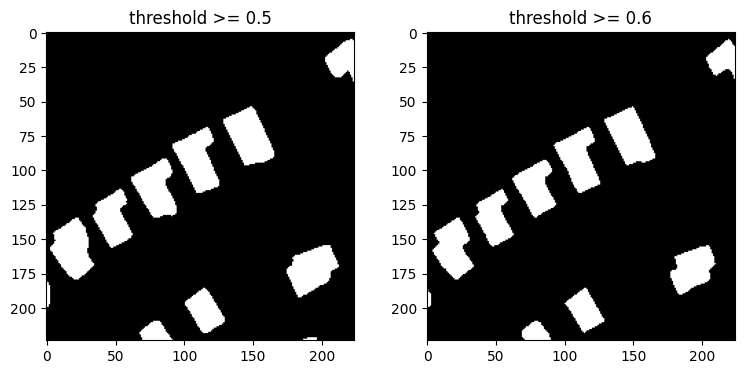

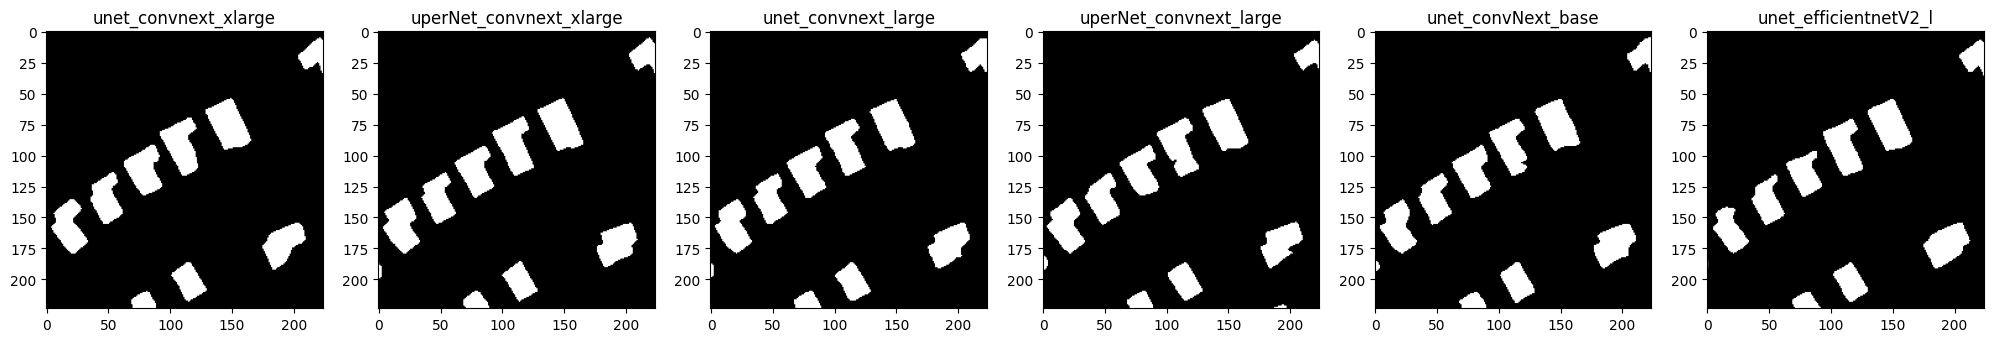

In [7]:
import pandas as pd
import numpy as np
# RLE 디코딩 함수
def rle_decode(mask_rle, shape=(224,224)):
    if mask_rle == -1 or mask_rle == '-1':
        return np.zeros(shape)
     
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 데이터 불러오기
# submit1 = pd.read_csv('./convNext_base_epoch_53_best.csv')
submit0 = pd.read_csv('/home/ubin108/0728_ensemble_6_building_3_threshold_0.55_[30, 30, 20, 20, 20, 20].csv')
submit1 = pd.read_csv('/home/ubin108/0728_unet_convNext_xlarge_mask0.55.csv')
submit2 = pd.read_csv('/home/ubin108/0728_uper_convnext_xlarge_best_8178_95_mask_0.55.csv')
submit3 = pd.read_csv('/home/ubin108/0728_unet_convnext_large_in22ft1k_train95_mask0.6.csv')
submit4 = pd.read_csv('/home/ubin108/0727_upernet_convnext_large_0.80845_mask0.6.csv')
submit5 = pd.read_csv('/home/ubin108/0727_unet_efficientnetV2_l_80803_mask0.6.csv')
submit6 = pd.read_csv('/home/ubin108/0727_unet_convNext_base_8062_mask0.6.csv')
# 모든 행에 대해 반복
# for idx in range(len(submit1)):
#     # 각 행의 mask_rle을 가져옴
#     mask_rle1 = submit1.loc[idx, 'mask_rle']
#     mask_rle2 = submit2.loc[idx, 'mask_rle']
#     mask_rle3 = submit3.loc[idx, 'mask_rle']
#     mask_rle4 = submit4.loc[idx, 'mask_rle']
#     mask_rle5 = submit5.loc[idx, 'mask_rle']
#     # mask_rle 값이 -1인 경우의 수를 구함
#     minus_one_count = sum(1 for mask_rle in [mask_rle1, mask_rle2, mask_rle3, mask_rle4, mask_rle5] if mask_rle == '-1')

#     # 만약 하나 이상의 파일이 -1로 예측하고, 다른 파일이 -1이 아니라고 예측한 경우
#     if 1 <= minus_one_count <= 1:
#         print(f'{idx}, ')


idx=251

mask_rle0 = submit0.loc[idx, 'mask_rle']
mask_rle1 = submit1.loc[idx, 'mask_rle']
mask_rle2 = submit2.loc[idx, 'mask_rle']
mask_rle3 = submit3.loc[idx, 'mask_rle']
mask_rle4 = submit4.loc[idx, 'mask_rle']
mask_rle5 = submit5.loc[idx, 'mask_rle']
mask_rle6 = submit6.loc[idx, 'mask_rle']
mask0 = rle_decode(mask_rle0, (224, 224))
mask1 = rle_decode(mask_rle1, (224, 224))
mask2 = rle_decode(mask_rle2, (224, 224))
mask3 = rle_decode(mask_rle3, (224, 224))
mask4 = rle_decode(mask_rle4, (224, 224))
mask5 = rle_decode(mask_rle5, (224, 224))
mask6 = rle_decode(mask_rle6, (224, 224))
# 이미지를 화면에 출력
# Display the test image separately
test_image = mpimg.imread(f'./data/test_img/TEST_{idx:05}.png')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))  # Change to 2 subplots
axs[0].imshow(test_image, cmap='gray')
axs[0].set_title('Example Image')
axs[1].imshow(mask0, cmap='gray')
axs[1].set_title('Ensemble')

fig, axs = plt.subplots(1, 6, figsize=(25, 4))  # Change to 4 subplots instead of 5
axs[0].imshow(mask6, cmap='gray'), axs[0].set_title('unet_convnext_xlarge')
axs[1].imshow(mask1, cmap='gray'), axs[1].set_title('uperNet_convnext_xlarge')
axs[2].imshow(mask2, cmap='gray'), axs[2].set_title('unet_convnext_large')
axs[3].imshow(mask3, cmap='gray'), axs[3].set_title('uperNet_convnext_large')
axs[4].imshow(mask4, cmap='gray'), axs[4].set_title('unet_convNext_base')
axs[5].imshow(mask5, cmap='gray'), axs[5].set_title('unet_efficientnetV2_l')

plt.show()

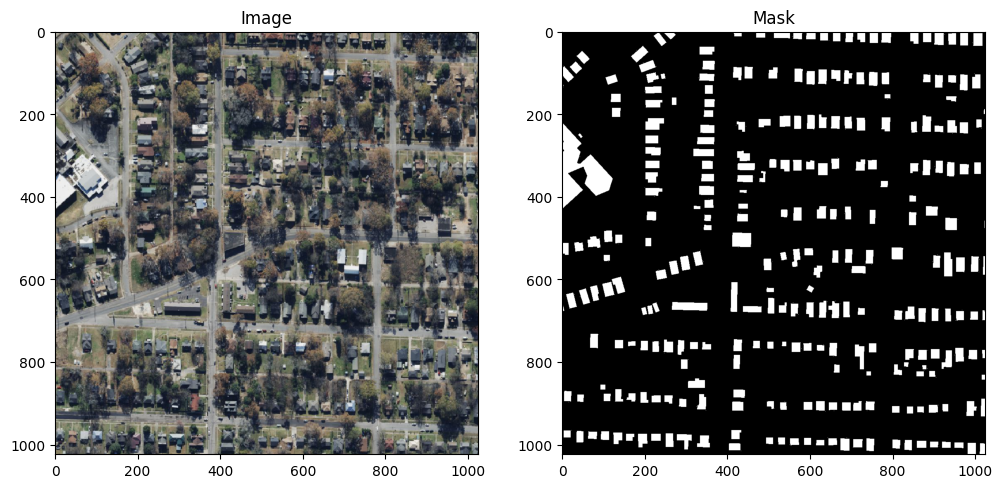

In [26]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def rle_decode(mask_rle, shape=(1024, 1024)):

    if mask_rle == -1 or mask_rle == '-1':
        return np.zeros(shape)
     
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# csv 파일 읽기
df = pd.read_csv('./train.csv')

idx = 999
img_path = df.loc[idx, 'img_path']
mask_rle = df.loc[idx, 'mask_rle']
img = Image.open(img_path)
img_array = np.array(img)
mask = rle_decode(mask_rle)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_array)
axes[0].set_title('Image')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
plt.show()